In [69]:
import io
import zipfile
import sqlite3
import requests
import pandas as pd
import os
import matplotlib.pyplot as plt

EJECTIONS_ZIP_URL = "https://www.retrosheet.org/ejections.zip"
DB_NAME = "ejections.db"
TABLE_NAME = "ejections"


DOWNLOAD THE EJECTIONS CSV FILE FROM RETROSHEET

In [70]:
def download_zip(url: str) -> io.BytesIO:
    """
    Download the ZIP file from Retrosheet and return it as a BytesIO object.
    """
    print(f"Downloading: {url}")
    resp = requests.get(url)
    resp.raise_for_status()
    print("Download complete.")
    return io.BytesIO(resp.content)


In [71]:
def read_ejections_csv(zip_bytes: io.BytesIO) -> pd.DataFrame:
    """
    Reads the Retrosheet ejections CSV, which may contain unescaped commas.
    Uses the Python engine for more flexibility in parsing.
    """
    with zipfile.ZipFile(zip_bytes) as zf:
        members = zf.namelist()
        print("Files inside ZIP:", members)

        csv_files = [m for m in members if m.lower().endswith((".csv", ".txt"))]
        if not csv_files:
            raise RuntimeError("No CSV/TXT file found inside ZIP.")

        data_file = csv_files[0]
        print(f"Reading: {data_file}")

        col_names = [
            "game_id",
            "date",
            "game_number",
            "ejectee_id",
            "ejectee_name",
            "ejectee_team",
            "ejectee_role",
            "umpire_id",
            "umpire_name",
            "inning",
            "reason",
        ]

        with zf.open(data_file) as f:
            df = pd.read_csv(
                f,
                header=None,
                names=col_names,
                dtype=str,
                encoding="latin-1",
                engine="python",        # ← critical fix
                on_bad_lines="warn",    # skip badly formatted lines instead of crashing
                sep=",",                # CSV-style
            )

    print("Loaded dataframe:")
    display(df.head())
    print(df.shape)

    return df


In [72]:
def save_to_sqlite(df: pd.DataFrame, db_path: str, table_name: str):
    """
    Save the DataFrame to SQLite as a table.
    """
    db_path_full = os.path.join(os.getcwd(), db_path)

    conn = sqlite3.connect(db_path_full)
    df.to_sql(table_name, conn, if_exists="replace", index=False)
    conn.close()

    print(f"Saved {len(df)} rows to '{table_name}' in database '{db_path_full}'.")


In [73]:
zip_bytes = download_zip(EJECTIONS_ZIP_URL)
df = read_ejections_csv(zip_bytes)
save_to_sqlite(df, DB_NAME, TABLE_NAME)


Downloading: https://www.retrosheet.org/ejections.zip
Download complete.
Files inside ZIP: ['ejections.csv']
Reading: ejections.csv
Loaded dataframe:


C:\Users\Bryan\AppData\Local\Temp\ipykernel_28832\466758907.py:32: ParserWarning: Skipping line 2002: Expected 11 fields in line 2002, saw 12

  df = pd.read_csv(
C:\Users\Bryan\AppData\Local\Temp\ipykernel_28832\466758907.py:32: ParserWarning: Skipping line 2003: Expected 11 fields in line 2003, saw 12

  df = pd.read_csv(


,game_id,date,game_number,ejectee_id,ejectee_name,ejectee_team,ejectee_role,umpire_id,umpire_name,inning,reason
0,GAMEID,DATE,DH,EJECTEE,EJECTEENAME,TEAM,JOB,UMPIRE,UMPIRENAME,INNING,REASON
1,CL6188905250,05/25/1889,NaN,orr-d101,Dave Orr,CL6,P,goldf101,Fred Goldsmith,-1,Call at 3B
2,BL2188905280,05/28/1889,NaN,tuckt103,Tommy Tucker,BL2,P,gaffj801,John Gaffney,-1,Yelling at OF chasing fly
3,WS8188906010,06/01/1889,NaN,ewinb101,Buck Ewing,NY1,P,currw101,Wes Curry,-1,Obscene language
4,WS8188907300,07/30/1889,NaN,ewinb101,Buck Ewing,NY1,P,bakep101,Phil Baker,-1,Call at 1B


(19729, 11)
Saved 19729 rows to 'ejections' in database 'c:\Users\Bryan\dsci510_fall2025_final_project\ejections.db'.


In [74]:
conn = sqlite3.connect(DB_NAME)

example = pd.read_sql("""
SELECT ejectee_name, COUNT(*) AS total_ejections
FROM ejections
GROUP BY ejectee_name
ORDER BY total_ejections DESC
LIMIT 10;
""", conn)

conn.close()

example


,ejectee_name,total_ejections
0,Bobby Cox,165
1,John McGraw,141
2,Leo Durocher,134
3,Frankie Frisch,100
4,Earl Weaver,97
5,Tony LaRussa,93
6,Bruce Bochy,89
7,Clark Griffith,88
8,Ron Gardenhire,86
9,Joe Torre,85


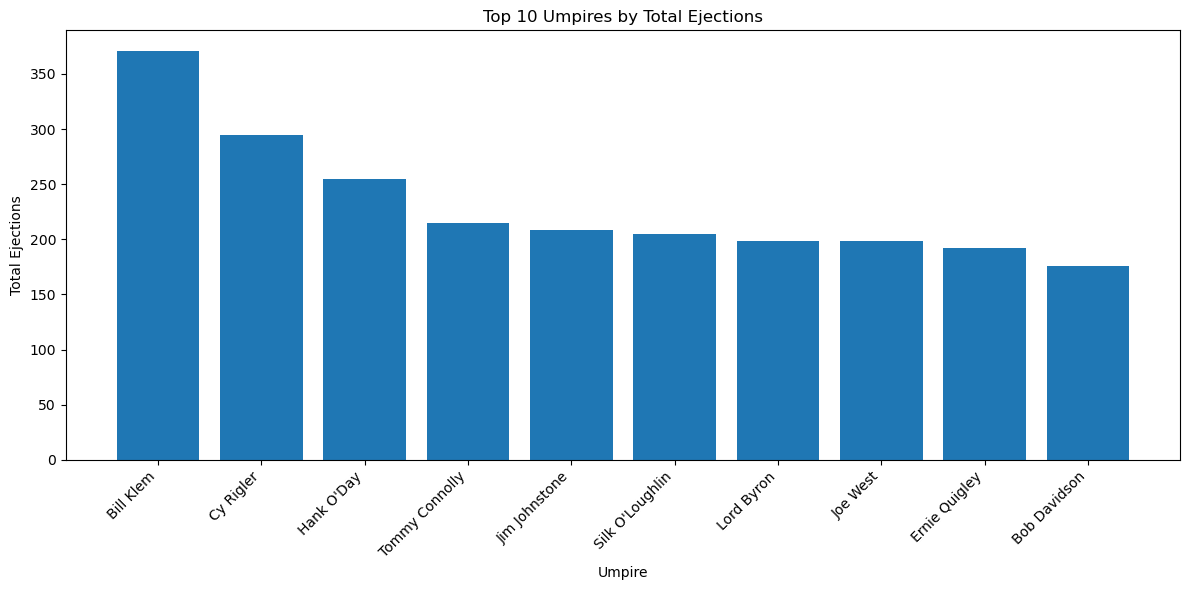

,umpire_name,total_ejections
0,Bill Klem,371
1,Cy Rigler,295
2,Hank O'Day,255
3,Tommy Connolly,215
4,Jim Johnstone,208
5,Silk O'Loughlin,205
6,Lord Byron,198
7,Joe West,198
8,Ernie Quigley,192
9,Bob Davidson,176


In [75]:
# top 10 umpires who have ejected players

# Path to your database 
DB_NAME = "ejections.db"

# 1. Query top 10 umpires by total ejections
conn = sqlite3.connect(DB_NAME)
query = """
SELECT 
    umpire_name,
    COUNT(*) AS total_ejections
FROM ejections
GROUP BY umpire_name
ORDER BY total_ejections DESC
LIMIT 10;
"""
top_umpires = pd.read_sql(query, conn)
conn.close()

# 2. Plot bar chart
plt.figure(figsize=(12, 6))
plt.bar(top_umpires["umpire_name"], top_umpires["total_ejections"])
plt.xticks(rotation=45, ha="right")
plt.xlabel("Umpire")
plt.ylabel("Total Ejections")
plt.title("Top 10 Umpires by Total Ejections")
plt.tight_layout()
plt.show()

# (optional) Also display the data table
top_umpires

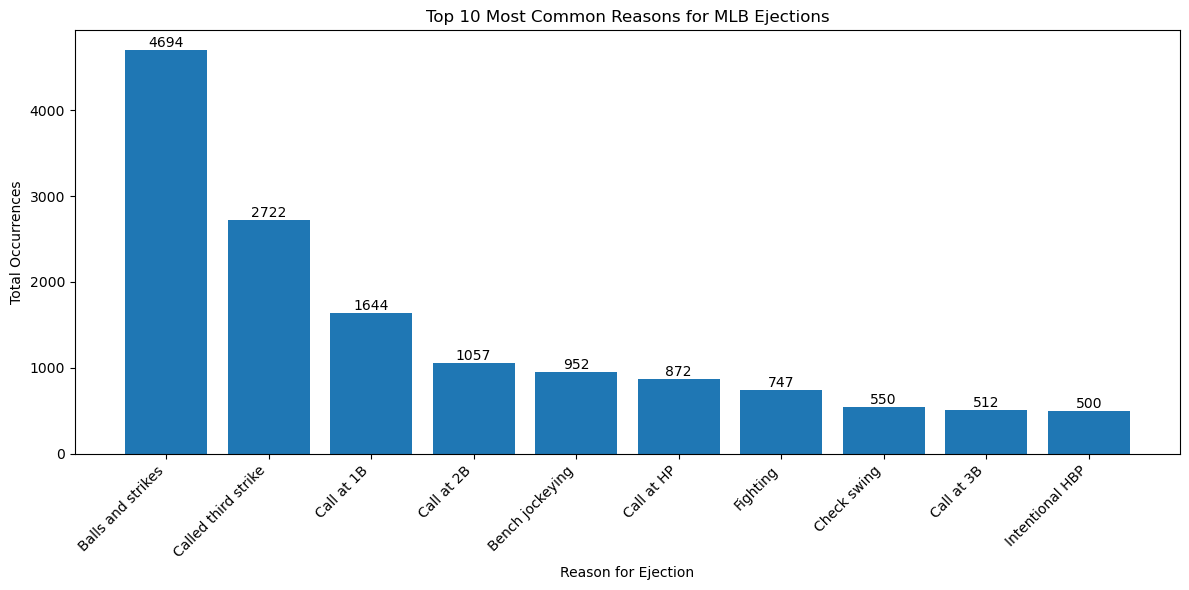

,reason,total_count
0,Balls and strikes,4694
1,Called third strike,2722
2,Call at 1B,1644
3,Call at 2B,1057
4,Bench jockeying,952
5,Call at HP,872
6,Fighting,747
7,Check swing,550
8,Call at 3B,512
9,Intentional HBP,500


In [76]:
# 1. Query: top 10 ejection reasons
conn = sqlite3.connect(DB_NAME)
query = """
SELECT 
    reason,
    COUNT(*) AS total_count
FROM ejections
WHERE reason IS NOT NULL AND reason <> ''
GROUP BY reason
ORDER BY total_count DESC
LIMIT 10;
"""
top_reasons = pd.read_sql(query, conn)
conn.close()

# 2. Plot bar chart
plt.figure(figsize=(12, 6))
bars = plt.bar(top_reasons["reason"], top_reasons["total_count"])
plt.xticks(rotation=45, ha="right")
plt.xlabel("Reason for Ejection")
plt.ylabel("Total Occurrences")
plt.title("Top 10 Most Common Reasons for MLB Ejections")
plt.tight_layout()

# 3. Add value labels above bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        str(height),
        ha='center',
        va='bottom'
    )

plt.show()

# Show the table too
top_reasons

       ejectee_name  total_ejections
0      Johnny Evers               64
1  Heinie Zimmerman               46
2      Jim Piersall               36
3   Roger Bresnahan               35
4       Bill Dahlen               35
5       Larry Doyle               33
6    Gary Sheffield               33
7         Red Dooin               32
8        Dan McGann               31
9      Jimmy Austin               29


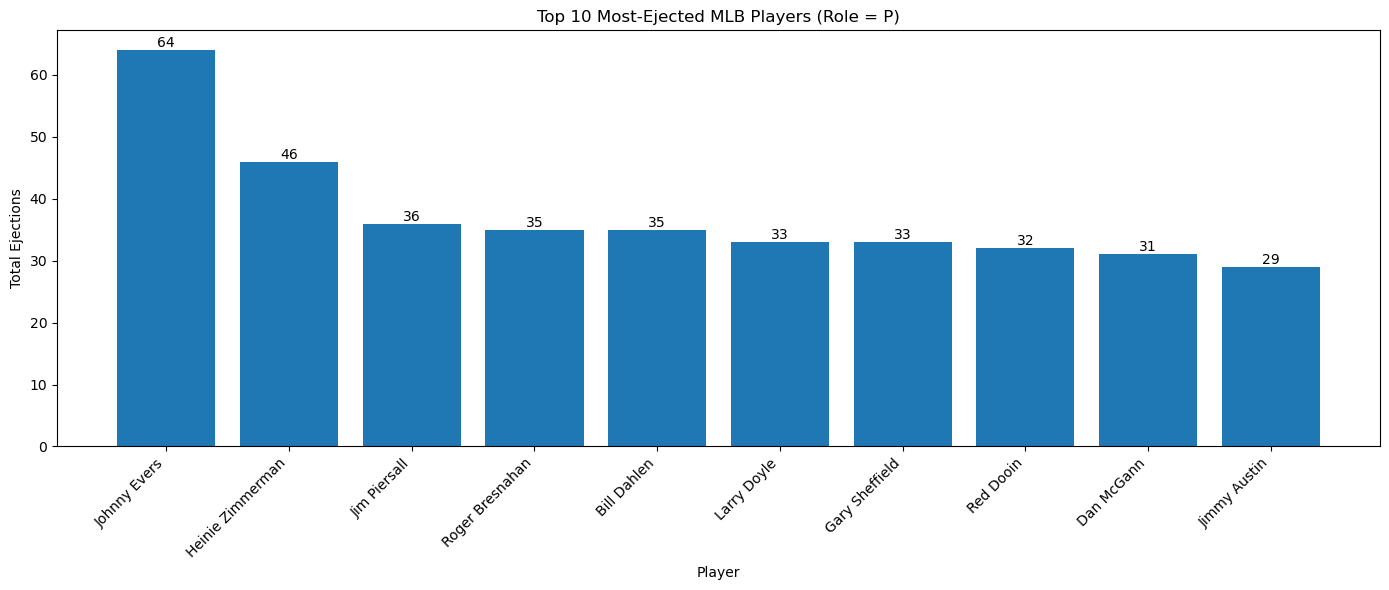

In [77]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

DB_NAME = "ejections.db"   # make sure this matches your filename

# 1. Query: top 10 ejected players (role code 'P')
conn = sqlite3.connect(DB_NAME)
query = """
SELECT 
    ejectee_name,
    COUNT(*) AS total_ejections
FROM ejections
WHERE ejectee_role = 'P'
  AND ejectee_name IS NOT NULL 
  AND ejectee_name <> ''
GROUP BY ejectee_name
ORDER BY total_ejections DESC
LIMIT 10;
"""
top_players = pd.read_sql(query, conn)
conn.close()

print(top_players)  # optional: inspect the table

# 2. Bar chart
plt.figure(figsize=(14, 6))
bars = plt.bar(top_players["ejectee_name"], top_players["total_ejections"])
plt.xticks(rotation=45, ha="right")
plt.xlabel("Player")
plt.ylabel("Total Ejections")
plt.title("Top 10 Most-Ejected MLB Players (Role = P)")
plt.tight_layout()

# 3. Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        str(height),
        ha="center",
        va="bottom"
    )

plt.show()


Video review was added to the MLB after 08/28/2008

          umpire_name  total_ejections
0            Joe West               64
1       Vic Carapazza               62
2  Hunter Wendelstedt               62
3         Dan Bellino               57
4        Doug Eddings               52
5          Bill Welke               52
6         Jeff Nelson               51
7       Marvin Hudson               50
8         Will Little               49
9      Mike Estabrook               49


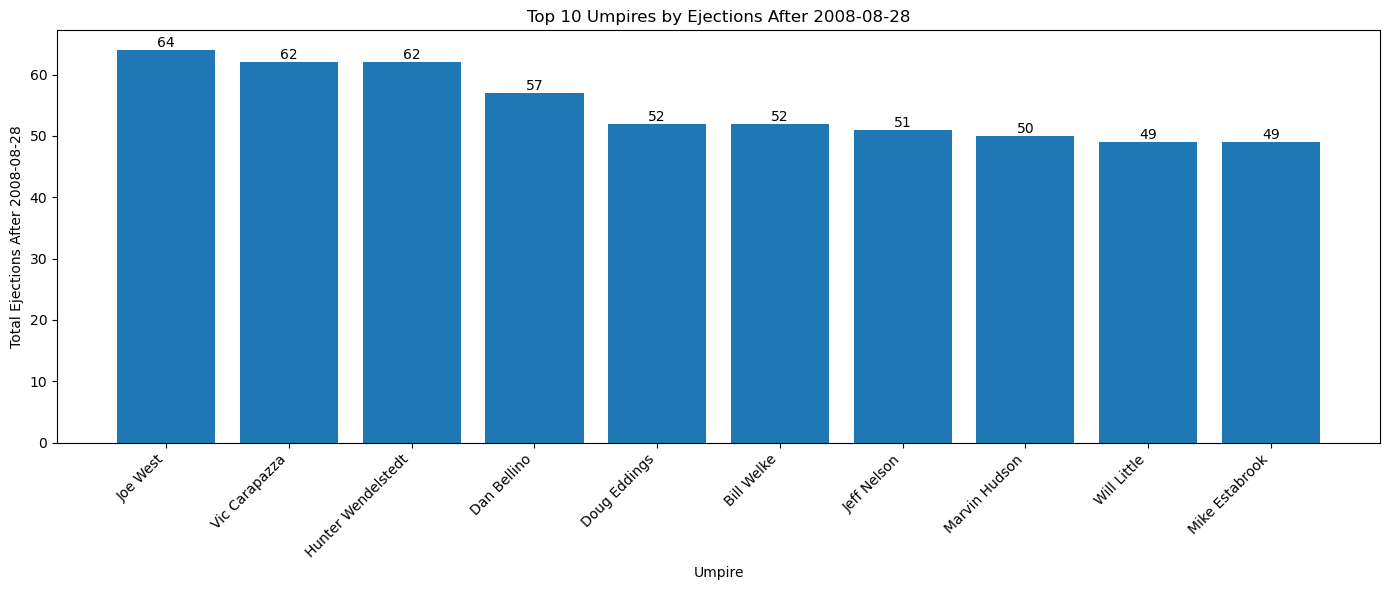

In [78]:


# 1. Query: top 10 umpires after 2008-08-28
conn = sqlite3.connect(DB_NAME)

query = """
SELECT 
    umpire_name,
    COUNT(*) AS total_ejections
FROM ejections
WHERE date <> 'DATE'  -- skip header row
  AND date(
        substr(date,7,4) || '-' ||  -- YYYY
        substr(date,1,2) || '-' ||  -- MM
        substr(date,4,2)            -- DD
      ) > date('2008-08-28')
  AND umpire_name IS NOT NULL
  AND umpire_name <> ''
GROUP BY umpire_name
ORDER BY total_ejections DESC
LIMIT 10;
"""

top_umpires_after = pd.read_sql(query, conn)
conn.close()

print(top_umpires_after)  # optional: inspect table

# 2. Bar chart
plt.figure(figsize=(14, 6))
bars = plt.bar(top_umpires_after["umpire_name"], top_umpires_after["total_ejections"])
plt.xticks(rotation=45, ha="right")
plt.xlabel("Umpire")
plt.ylabel("Total Ejections After 2008-08-28")
plt.title("Top 10 Umpires by Ejections After 2008-08-28")
plt.tight_layout()

# 3. Add labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        str(height),
        ha="center",
        va="bottom"
    )

plt.show()


In [79]:
# 1. Query: top 10 umpires between 2015–2022
conn = sqlite3.connect(DB_NAME)

query = """
SELECT 
    umpire_name,
    COUNT(*) AS total_ejections
FROM ejections
WHERE date <> 'DATE'  -- skip header row
  AND umpire_name IS NOT NULL
  AND umpire_name <> ''
  AND date(
        substr(date,7,4) || '-' ||  -- YYYY
        substr(date,1,2) || '-' ||  -- MM
        substr(date,4,2)            -- DD
      ) BETWEEN date('2015-01-01') AND date('2022-12-31')
GROUP BY umpire_name
ORDER BY total_ejections DESC
LIMIT 10;
"""

top_umpires_2015_2022 = pd.read_sql(query, conn)
conn.close()


In [80]:
top_umpires_2015_2022.to_csv("top_umpires_2015_2022.csv", index=False)


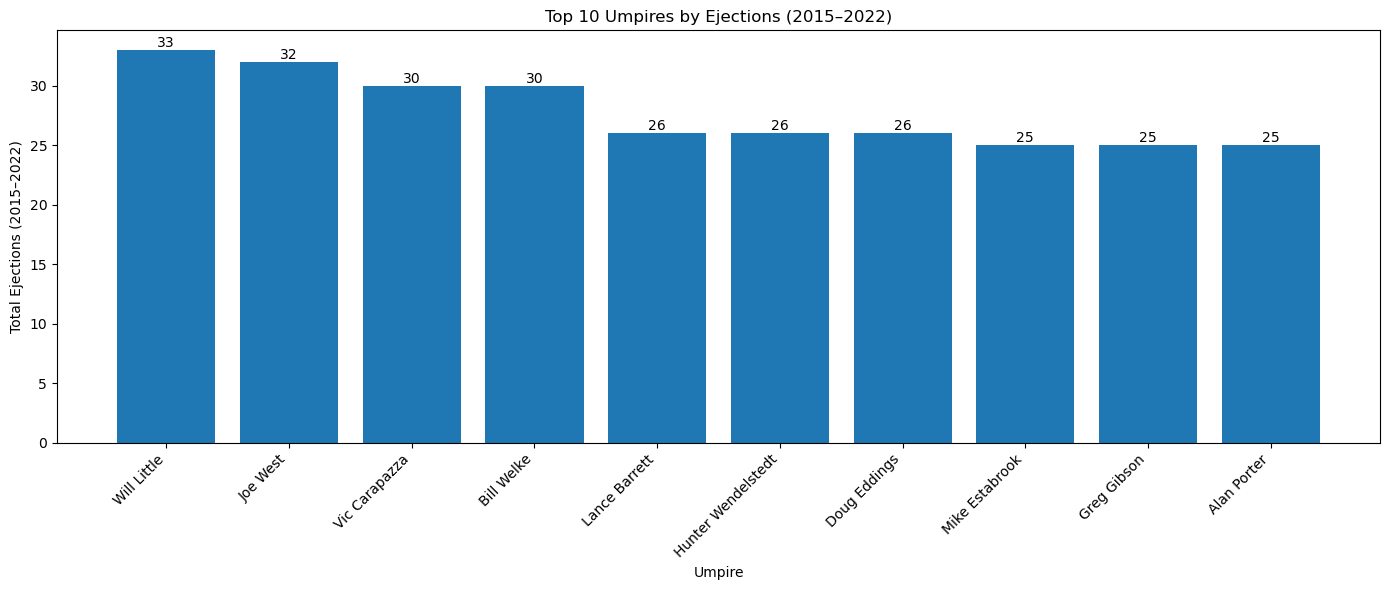

In [81]:
plt.figure(figsize=(14, 6))
bars = plt.bar(top_umpires_2015_2022["umpire_name"],
               top_umpires_2015_2022["total_ejections"])

plt.xticks(rotation=45, ha="right")
plt.xlabel("Umpire")
plt.ylabel("Total Ejections (2015–2022)")
plt.title("Top 10 Umpires by Ejections (2015–2022)")
plt.tight_layout()

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        str(height),
        ha="center",
        va="bottom"
    )

plt.show()


In [82]:
DB_NAME = "ejections.db"

# 1. Query reasons Joe West issued ejections after 2008-08-28
conn = sqlite3.connect(DB_NAME)

query = """
SELECT 
    reason,
    COUNT(*) AS total_count
FROM ejections
WHERE umpire_name = 'Joe West'
  AND reason IS NOT NULL 
  AND reason <> ''
  AND date <> 'DATE'
  AND date(
        substr(date,7,4) || '-' || 
        substr(date,1,2) || '-' ||
        substr(date,4,2)
      ) > date('2008-08-28')
GROUP BY reason
ORDER BY total_count DESC;
"""

west_reasons = pd.read_sql(query, conn)
conn.close()

west_reasons

,reason,total_count
0,Fighting,7
1,Balls and strikes,7
2,Called third strike,6
3,Call at 1B,4
4,Bench-clearing altercation,3
5,Interference non-call,2
6,Interference call,2
7,Intentional hit by pitch,2
8,Intentional HBP,2
9,Home run replay ruling,2


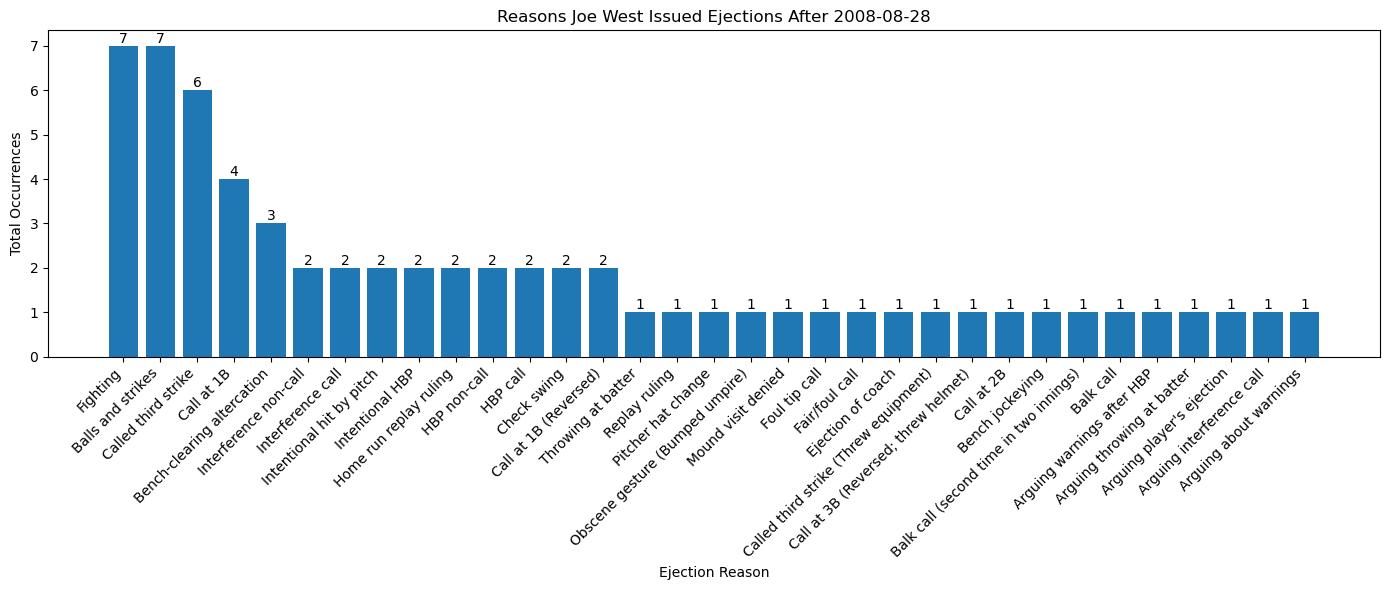

In [83]:
plt.figure(figsize=(14, 6))
bars = plt.bar(west_reasons["reason"], west_reasons["total_count"])
plt.xticks(rotation=45, ha="right")
plt.xlabel("Ejection Reason")
plt.ylabel("Total Occurrences")
plt.title("Reasons Joe West Issued Ejections After 2008-08-28")
plt.tight_layout()

# Add number labels above bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        str(height),
        ha="center",
        va="bottom"
    )

plt.show()


In [84]:
# 1. Query: top 10 reasons after 2008-08-28
conn = sqlite3.connect(DB_NAME)

query = """
SELECT 
    reason,
    COUNT(*) AS total_count
FROM ejections
WHERE reason IS NOT NULL 
  AND reason <> ''
  AND date <> 'DATE'
  AND date(
        substr(date,7,4) || '-' || 
        substr(date,1,2) || '-' || 
        substr(date,4,2)
      ) > date('2008-08-28')
GROUP BY reason
ORDER BY total_count DESC
LIMIT 10;
"""

top10_reasons_after = pd.read_sql(query, conn)
conn.close()

top10_reasons_after

,reason,total_count
0,Balls and strikes,908
1,Called third strike,715
2,Check swing,204
3,Intentional HBP,118
4,Fighting,99
5,Call at 1B,84
6,Replay ruling,50
7,Call at 2B,48
8,Balk call,48
9,Fair/foul call,40


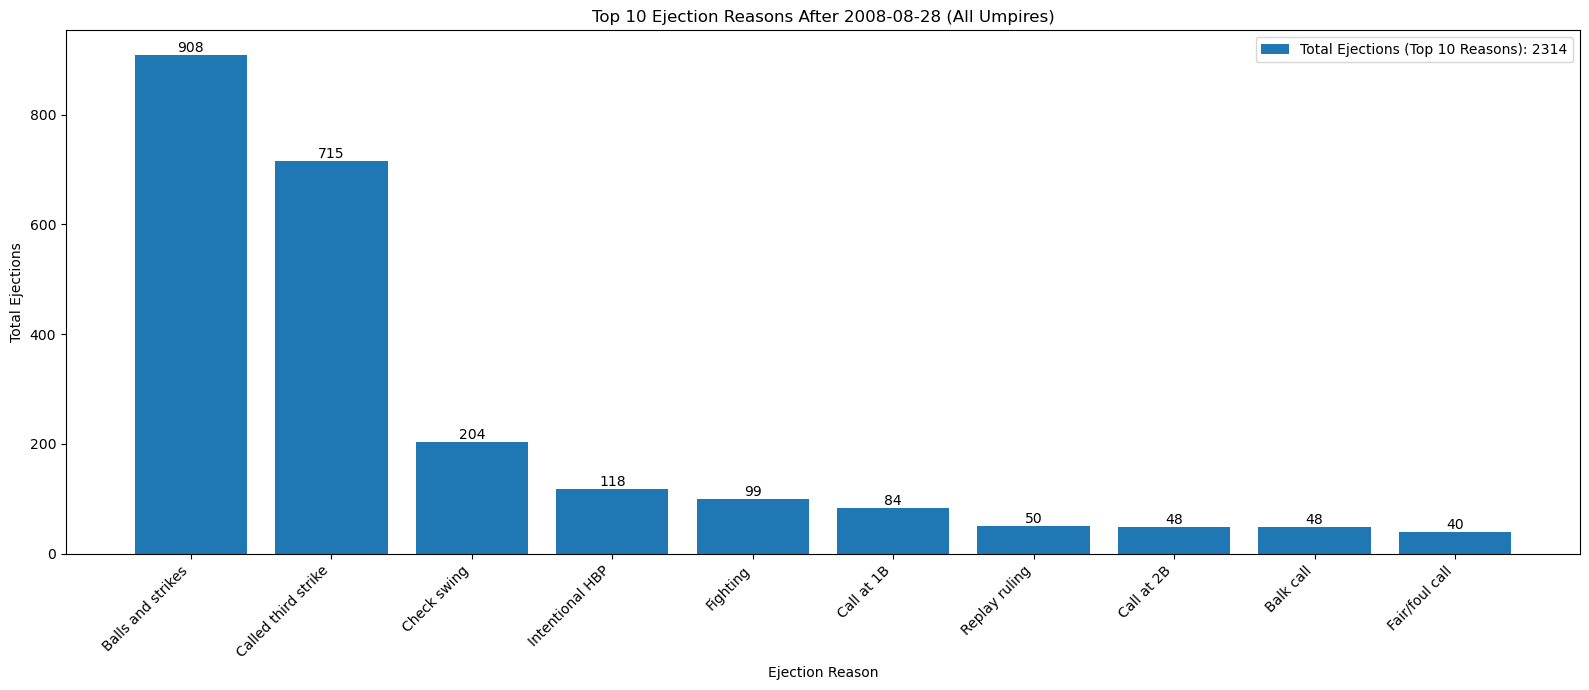

In [85]:
# Calculate total ejections in the top 10
total_top10 = top10_reasons_after["total_count"].sum()

plt.figure(figsize=(16, 7))
bars = plt.bar(top10_reasons_after["reason"], top10_reasons_after["total_count"])
plt.xticks(rotation=45, ha="right")
plt.xlabel("Ejection Reason")
plt.ylabel("Total Ejections")
plt.title("Top 10 Ejection Reasons After 2008-08-28 (All Umpires)")

# Add legend showing total ejections in the dataset
plt.legend([f"Total Ejections (Top 10 Reasons): {total_top10}"])

plt.tight_layout()

# Add number labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        str(height),
        ha="center",
        va="bottom"
    )

plt.show()


NEW STUFF

In [86]:
import io
import zipfile
import requests
import pandas as pd
import os
import matplotlib.pyplot as plt

EJECTIONS_ZIP_URL = "https://www.retrosheet.org/ejections.zip"


In [87]:
def download_zip(url: str) -> io.BytesIO:
    """
    Download the ZIP file from Retrosheet and return it as a BytesIO object.
    """
    print(f"Downloading: {url}")
    resp = requests.get(url)
    resp.raise_for_status()
    print("Download complete.")
    return io.BytesIO(resp.content)


In [88]:
def read_ejections_csv(zip_bytes: io.BytesIO) -> pd.DataFrame:
    """
    Reads the Retrosheet ejections CSV, which may contain unescaped commas.
    Uses the Python engine for more flexibility in parsing.
    (Keep your existing column logic here if you had it.)
    """
    with zipfile.ZipFile(zip_bytes) as zf:
        members = zf.namelist()
        print("Files inside ZIP:", members)

        csv_files = [m for m in members if m.lower().endswith((".csv", ".txt"))]
        if not csv_files:
            raise RuntimeError("No CSV/TXT file found inside ZIP.")

        data_file = csv_files[0]
        print(f"Reading: {data_file}")

        # You can reuse the parsing logic you already had – here’s a generic example:
        df = pd.read_csv(
            zf.open(data_file),
            dtype=str,
            engine="python",
            on_bad_lines="warn",
        )

    print("Loaded dataframe:")
    display(df.head())
    print(df.shape)
    return df


In [89]:
zip_bytes = download_zip(EJECTIONS_ZIP_URL)
df = read_ejections_csv(zip_bytes)

# Basic cleaning to mimic the SQLite filters you had
df = df.copy()

# Drop weird header row where date == 'DATE', if present
if "date" in df.columns:
    df = df[df["date"] != "DATE"]

# Parse date into datetime for easier filtering
if "date" in df.columns:
    df["date_parsed"] = pd.to_datetime(
        df["date"], format="%m/%d/%Y", errors="coerce"
    )

df.head()


Downloading: https://www.retrosheet.org/ejections.zip
Download complete.
Files inside ZIP: ['ejections.csv']
Reading: ejections.csv
Loaded dataframe:


C:\Users\Bryan\AppData\Local\Temp\ipykernel_28832\4055199785.py:19: ParserWarning: Skipping line 2002: Expected 11 fields in line 2002, saw 12

  df = pd.read_csv(
C:\Users\Bryan\AppData\Local\Temp\ipykernel_28832\4055199785.py:19: ParserWarning: Skipping line 2003: Expected 11 fields in line 2003, saw 12

  df = pd.read_csv(


,GAMEID,DATE,DH,EJECTEE,EJECTEENAME,TEAM,JOB,UMPIRE,UMPIRENAME,INNING,REASON
0,CL6188905250,05/25/1889,NaN,orr-d101,Dave Orr,CL6,P,goldf101,Fred Goldsmith,-1,Call at 3B
1,BL2188905280,05/28/1889,NaN,tuckt103,Tommy Tucker,BL2,P,gaffj801,John Gaffney,-1,Yelling at OF chasing fly
2,WS8188906010,06/01/1889,NaN,ewinb101,Buck Ewing,NY1,P,currw101,Wes Curry,-1,Obscene language
3,WS8188907300,07/30/1889,NaN,ewinb101,Buck Ewing,NY1,P,bakep101,Phil Baker,-1,Call at 1B
4,LS2188908100,08/10/1889,NaN,raymh101,Harry Raymond,LS2,P,goldf101,Fred Goldsmith,-1,Call at 2B


(19728, 11)


,GAMEID,DATE,DH,EJECTEE,EJECTEENAME,TEAM,JOB,UMPIRE,UMPIRENAME,INNING,REASON
0,CL6188905250,05/25/1889,NaN,orr-d101,Dave Orr,CL6,P,goldf101,Fred Goldsmith,-1,Call at 3B
1,BL2188905280,05/28/1889,NaN,tuckt103,Tommy Tucker,BL2,P,gaffj801,John Gaffney,-1,Yelling at OF chasing fly
2,WS8188906010,06/01/1889,NaN,ewinb101,Buck Ewing,NY1,P,currw101,Wes Curry,-1,Obscene language
3,WS8188907300,07/30/1889,NaN,ewinb101,Buck Ewing,NY1,P,bakep101,Phil Baker,-1,Call at 1B
4,LS2188908100,08/10/1889,NaN,raymh101,Harry Raymond,LS2,P,goldf101,Fred Goldsmith,-1,Call at 2B


In [90]:
example = (
    df.dropna(subset=["EJECTEENAME"])
      .loc[df["EJECTEENAME"].str.strip() != ""]
      .groupby("EJECTEENAME")
      .size()
      .reset_index(name="total_ejections")
      .sort_values("total_ejections", ascending=False)
      .head(10)
)

example


,EJECTEENAME,total_ejections
486,Bobby Cox,165
2469,John McGraw,141
2845,Leo Durocher,134
1561,Frankie Frisch,100
1307,Earl Weaver,97
4167,Tony LaRussa,93
593,Bruce Bochy,89
855,Clark Griffith,88
3706,Ron Gardenhire,86
2414,Joe Torre,85


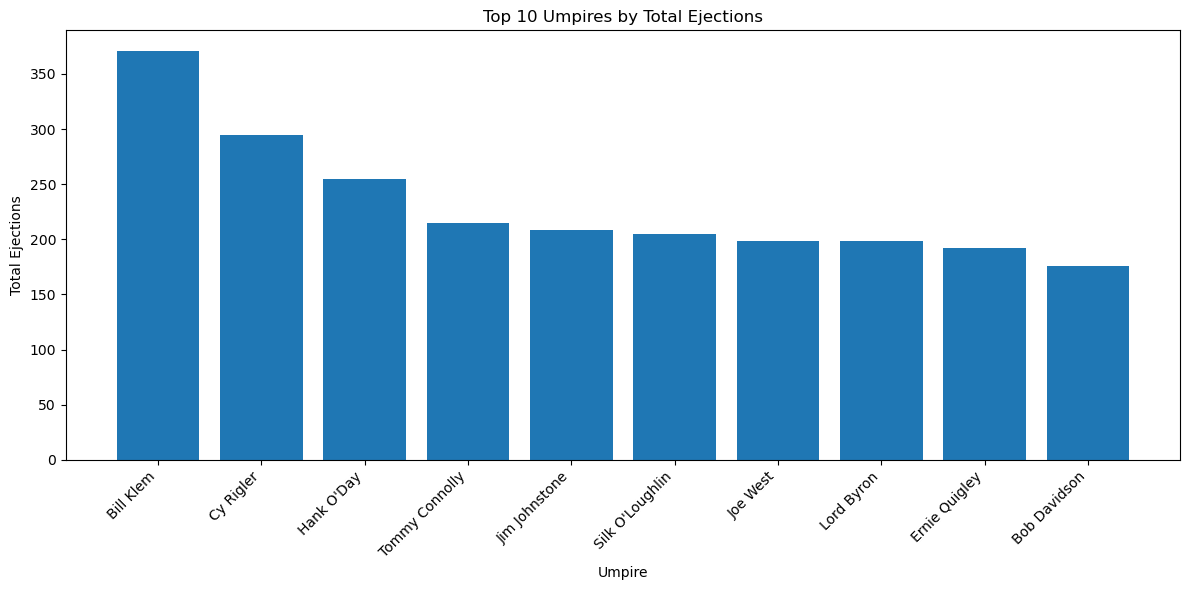

,UMPIRENAME,total_ejections
59,Bill Klem,371
137,Cy Rigler,295
254,Hank O'Day,255
524,Tommy Connolly,215
302,Jim Johnstone,208
485,Silk O'Loughlin,205
322,Joe West,198
376,Lord Byron,198
208,Ernie Quigley,192
77,Bob Davidson,176


In [91]:
top_umpires = (
    df.dropna(subset=["UMPIRENAME"])
      .loc[df["UMPIRENAME"].str.strip() != ""]
      .groupby("UMPIRENAME")
      .size()
      .reset_index(name="total_ejections")
      .sort_values("total_ejections", ascending=False)
      .head(10)
)

plt.figure(figsize=(12, 6))
bars = plt.bar(top_umpires["UMPIRENAME"], top_umpires["total_ejections"])
plt.xticks(rotation=45, ha="right")
plt.xlabel("Umpire")
plt.ylabel("Total Ejections")
plt.title("Top 10 Umpires by Total Ejections")
plt.tight_layout()
plt.show()

top_umpires


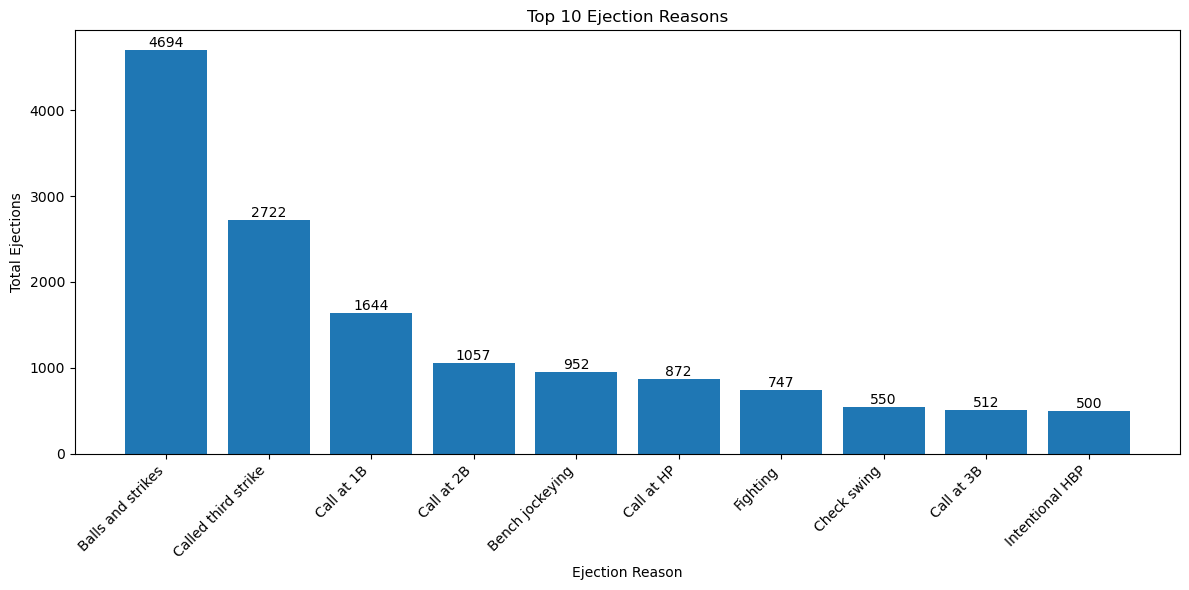

,REASON,total_count
240,Balls and strikes,4694
579,Called third strike,2722
389,Call at 1B,1644
456,Call at 2B,1057
348,Bench jockeying,952
539,Call at HP,872
880,Fighting,747
677,Check swing,550
505,Call at 3B,512
994,Intentional HBP,500


In [92]:
top_reasons = (
    df.dropna(subset=["REASON"])
      .loc[df["REASON"].str.strip() != ""]
      .groupby("REASON")
      .size()
      .reset_index(name="total_count")
      .sort_values("total_count", ascending=False)
      .head(10)
)

plt.figure(figsize=(12, 6))
bars = plt.bar(top_reasons["REASON"], top_reasons["total_count"])
plt.xticks(rotation=45, ha="right")
plt.xlabel("Ejection Reason")
plt.ylabel("Total Ejections")
plt.title("Top 10 Ejection Reasons")
plt.tight_layout()

# Add labels
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        str(height),
        ha="center",
        va="bottom",
    )

plt.show()

top_reasons


In [93]:
df = pd.read_csv("ejections.csv", on_bad_lines="warn")


C:\Users\Bryan\AppData\Local\Temp\ipykernel_28832\3389023338.py:1: ParserWarning: Skipping line 2002: expected 11 fields, saw 12
Skipping line 2003: expected 11 fields, saw 12

  df = pd.read_csv("ejections.csv", on_bad_lines="warn")


In [94]:
import pandas as pd

# 1. Load data
# Prefer using in-memory 'df' if already loaded, otherwise read file robustly
if "df" in globals() and isinstance(df, pd.DataFrame):
    ejections = df.copy()
else:
    ejections = pd.read_csv(
        "ejections.csv",
        dtype=str,
        encoding="latin-1",
        engine="python",
        on_bad_lines="warn",
    )

# Normalize column names to uppercase and strip whitespace (downstream expects UMPIRENAME, TEAM, DATE)
ejections.columns = [c.strip().upper() for c in ejections.columns]
scorecards = pd.read_csv("data/mlb-umpire-scorecard.csv")

# 2. Parse dates
ejections["DATE"] = pd.to_datetime(ejections["DATE"], format="%m/%d/%Y", errors="coerce")
scorecards["date"] = pd.to_datetime(scorecards["date"], errors="coerce")

# 3. Filter ejections to 2015–2021
mask = (ejections["DATE"].dt.year >= 2015) & (ejections["DATE"].dt.year <= 2021)
ejections_filtered = ejections[mask].copy()

# 4. Clean strings (remove extra spaces)
ejections_filtered["UMPIRENAME"] = ejections_filtered["UMPIRENAME"].str.strip()
ejections_filtered["TEAM"] = ejections_filtered["TEAM"].str.strip()

scorecards["umpire"] = scorecards["umpire"].str.strip()
scorecards["home"] = scorecards["home"].str.strip()
scorecards["away"] = scorecards["away"].str.strip()

# 5. Merge where TEAM is the HOME team
home_overlap = pd.merge(
    ejections_filtered,
    scorecards,
    left_on=["UMPIRENAME", "TEAM", "DATE"],
    right_on=["umpire", "home", "date"],
    how="inner",
    suffixes=("_ej", "_sc"),
)

# 6. Merge where TEAM is the AWAY team
away_overlap = pd.merge(
    ejections_filtered,
    scorecards,
    left_on=["UMPIRENAME", "TEAM", "DATE"],
    right_on=["umpire", "away", "date"],
    how="inner",
    suffixes=("_ej", "_sc"),
)

# 7. Combine home + away matches and drop duplicates
overlap = pd.concat([home_overlap, away_overlap], ignore_index=True).drop_duplicates()

print("Number of overlapping rows:", len(overlap))
print("Date range in overlap:", overlap["DATE"].min(), "to", overlap["DATE"].max())

# 8. Save output
overlap.to_csv("output.csv", index=False)
print("Saved to output.csv")


Number of overlapping rows: 586
Date range in overlap: 2015-04-10 00:00:00 to 2021-09-25 00:00:00
Saved to output.csv


In [95]:
df = pd.read_csv("output.csv")

In [96]:
df.columns


Index(['GAMEID', 'DATE', 'DH', 'EJECTEE', 'EJECTEENAME', 'TEAM', 'JOB',
       'UMPIRE', 'UMPIRENAME', 'INNING', 'REASON', 'id', 'date', 'umpire',
       'home', 'away', 'home_team_runs', 'away_team_runs', 'pitches_called',
       'incorrect_calls', 'expected_incorrect_calls', 'correct_calls',
       'expected_correct_calls', 'correct_calls_above_expected', 'accuracy',
       'expected_accuracy', 'accuracy_above_expected', 'consistency',
       'favor_home', 'total_run_impact'],
      dtype='object')

In [97]:
# 1. Identify whether the ejected team is HOME or AWAY
df["is_home"] = df["TEAM"] == df["home"]
df["is_away"] = df["TEAM"] == df["away"]

In [98]:
# 2. Determine whether the ejected team won the game
def team_won(row):
    if row["is_home"]:
        return row["home_team_runs"] > row["away_team_runs"]
    elif row["is_away"]:
        return row["away_team_runs"] > row["home_team_runs"]
    return None  # should not occur

df["team_won"] = df.apply(team_won, axis=1)

In [99]:
# 3. Summaries
total_games = df["team_won"].notna().sum()
wins = df["team_won"].sum()       # True = win
losses = total_games - wins

win_pct = wins / total_games
loss_pct = losses / total_games

print("Total games with an ejection match:", total_games)
print("Wins after ejection:", wins)
print("Losses after ejection:", losses)
print("Win %:", round(win_pct, 3))
print("Loss %:", round(loss_pct, 3))

Total games with an ejection match: 586
Wins after ejection: 201
Losses after ejection: 385
Win %: 0.343
Loss %: 0.657


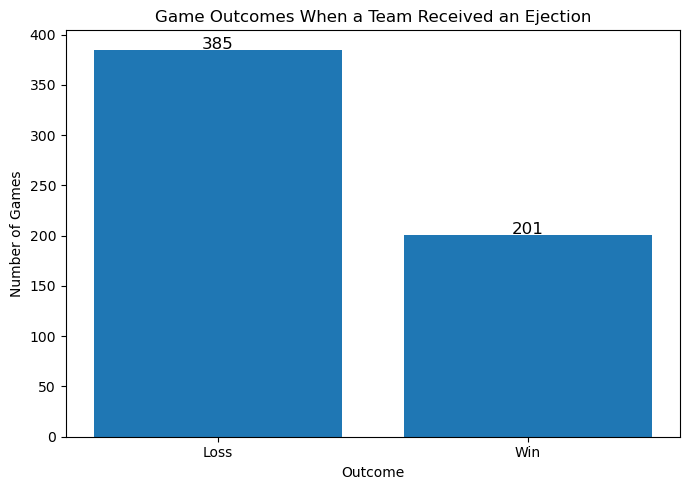

In [100]:
# Count wins and losses
counts = df["team_won"].value_counts().rename({True: "Win", False: "Loss"})

import matplotlib.pyplot as plt

# Plot bar chart
plt.figure(figsize=(7,5))
plt.bar(counts.index, counts.values)

plt.title("Game Outcomes When a Team Received an Ejection")
plt.xlabel("Outcome")
plt.ylabel("Number of Games")

# Add values above bars
for i, value in enumerate(counts.values):
    plt.text(i, value + 1, str(value), ha='center', fontsize=12)

plt.tight_layout()
plt.show()

In [101]:
import time
import requests
import pandas as pd

SCHEDULE_URL = "https://statsapi.mlb.com/api/v1/schedule"
GAME_FEED_URL = "https://statsapi.mlb.com/api/v1.1/game/{game_pk}/feed/live"


def get_game_pk(game_date: str, home_abbr: str, away_abbr: str | None = None) -> int | None:
    """
    Use MLB StatsAPI schedule endpoint to find the gamePk for a given date and home team.
    Optionally also match on away team to avoid ambiguity (doubleheaders, etc.).
    """
    params = {
        "sportId": 1,   # MLB
        "date": game_date,
        # you *can* filter by gameType ("R" for regular season), but it's optional:
        # "gameType": "R",
    }
    resp = requests.get(SCHEDULE_URL, params=params, timeout=10)
    resp.raise_for_status()
    data = resp.json()

    for date_block in data.get("dates", []):
        for g in date_block.get("games", []):
            home = g["teams"]["home"]["team"].get("abbreviation") or g["teams"]["home"]["team"].get("teamCode")
            away = g["teams"]["away"]["team"].get("abbreviation") or g["teams"]["away"]["team"].get("teamCode")

            # basic match: date + home team; if away_abbr is given, require that too
            if home == home_abbr and (away_abbr is None or away == away_abbr):
                return g["gamePk"]

    # No match found
    return None


def get_weather_for_game(game_pk: int | None):
    """
    Given a gamePk, call the MLB game feed endpoint and return weather info.
    Returns (condition, temp, wind) or (None, None, None) if unavailable.
    """
    if game_pk is None:
        return None, None, None

    url = GAME_FEED_URL.format(game_pk=game_pk)
    resp = requests.get(url, timeout=10)
    resp.raise_for_status()
    data = resp.json()

    weather = data.get("gameData", {}).get("weather", {}) or {}
    condition = weather.get("condition")
    temp = weather.get("temp")
    wind = weather.get("wind")

    return condition, temp, wind


def main():
    # 1. Load your overlap file (the one you called output.csv)
    df = pd.read_csv("output.csv")

    # Make sure DATE is in YYYY-MM-DD format as strings
    df["DATE"] = pd.to_datetime(df["DATE"]).dt.strftime("%Y-%m-%d")

    # We’ll use a cache so we only hit the API once per unique game
    # key: (DATE, home, away) -> (condition, temp, wind)
    weather_cache: dict[tuple[str, str, str], tuple[str | None, str | None, str | None]] = {}

    weather_condition = []
    weather_temp = []
    weather_wind = []

    for idx, row in df.iterrows():
        game_date = row["DATE"]
        home_team = row["home"]
        away_team = row["away"]  # you *could* skip this and just use home_team if you want

        key = (game_date, home_team, away_team)

        if key not in weather_cache:
            try:
                game_pk = get_game_pk(game_date, home_team, away_team)
                condition, temp, wind = get_weather_for_game(game_pk)
            except Exception as e:
                print(f"Row {idx}: error fetching weather for {key}: {e}")
                condition, temp, wind = None, None, None

            weather_cache[key] = (condition, temp, wind)

            # Be nice to the API
            time.sleep(0.2)

        condition, temp, wind = weather_cache[key]
        weather_condition.append(condition)
        weather_temp.append(temp)
        weather_wind.append(wind)

    # 3. Attach the new columns
    df["weather_condition"] = weather_condition
    df["weather_temp"] = weather_temp
    df["weather_wind"] = weather_wind

    # 4. Save to a new CSV
    df.to_csv("output_with_weather.csv", index=False)
    print("Saved file: output_with_weather.csv")


if __name__ == "__main__":
    main()


Saved file: output_with_weather.csv


In [102]:
import requests

date = "2015-04-10"
home = "MIL"
away = "PIT"

# Map 3-letter abbreviations to city or full name fragments
ABBR_TO_CITY = {
    "ARI": "Arizona",
    "ATL": "Atlanta",
    "BAL": "Baltimore",
    "BOS": "Boston",
    "CHC": "Chicago Cubs",
    "CHW": "Chicago White Sox",
    "CIN": "Cincinnati",
    "CLE": "Cleveland",
    "COL": "Colorado",
    "DET": "Detroit",
    "HOU": "Houston",
    "KCR": "Kansas City",
    "KCR": "Kansas City",
    "KCR": "Kansas City",
    "KCR": "Kansas City",
    "LAA": "Los Angeles Angels",
    "LAD": "Los Angeles Dodgers",
    "MIA": "Miami",
    "MIL": "Milwaukee",
    "MIN": "Minnesota",
    "NYM": "New York Mets",
    "NYY": "New York Yankees",
    "OAK": "Oakland",
    "PHI": "Philadelphia",
    "PIT": "Pittsburgh",
    "SDP": "San Diego",
    "SEA": "Seattle",
    "SFG": "San Francisco",
    "STL": "St. Louis",
    "TBR": "Tampa Bay",
    "TEX": "Texas",
    "TOR": "Toronto",
    "WSH": "Washington",
}

def abbr_to_city(abbr: str) -> str:
    return ABBR_TO_CITY.get(abbr.upper(), abbr)

def get_game_pk(game_date, home_abbr, away_abbr):
    url = "https://statsapi.mlb.com/api/v1/schedule"
    params = {"sportId": 1, "date": game_date}
    r = requests.get(url, params=params)
    r.raise_for_status()
    data = r.json()

    if not data.get("dates"):
        print("No games found on this date.")
        return None

    home_target = abbr_to_city(home_abbr).upper()
    away_target = abbr_to_city(away_abbr).upper()

    print("Games returned by MLB API on this date:")
    for d in data["dates"]:
        for g in d["games"]:
            home_name = g["teams"]["home"]["team"]["name"]
            away_name = g["teams"]["away"]["team"]["name"]
            print(g["gamePk"], away_name, "at", home_name)

    # Match by city substring in the full name
    for d in data["dates"]:
        for g in d["games"]:
            home_name = g["teams"]["home"]["team"]["name"].upper()
            away_name = g["teams"]["away"]["team"]["name"].upper()

            if home_target in home_name and away_target in away_name:
                print("\nMatched game:", g["gamePk"], away_name, "at", home_name)
                return g["gamePk"]

    print("No matching game found for", game_date, home_abbr, "vs", away_abbr)
    return None


def get_weather(game_pk):
    if game_pk is None:
        print("No gamePk found.")
        return

    url = f"https://statsapi.mlb.com/api/v1.1/game/{game_pk}/feed/live"
    r = requests.get(url)
    r.raise_for_status()
    data = r.json()

    weather = data.get("gameData", {}).get("weather", {}) or {}
    print("\nWeather object from API:")
    print(weather)
    return weather


# ----- RUN TEST -----
game_pk = get_game_pk(date, home, away)
print("\nFound gamePk:", game_pk)

weather = get_weather(game_pk)
print("\nFinal extracted weather:", weather)


Games returned by MLB API on this date:
413709 Toronto Blue Jays at Baltimore Orioles
413699 Houston Astros at Texas Rangers
413697 Chicago Cubs at Colorado Rockies
413698 Detroit Tigers at Cleveland Indians
413702 Minnesota Twins at Chicago White Sox
413710 Washington Nationals at Philadelphia Phillies
413696 Boston Red Sox at New York Yankees
413707 St. Louis Cardinals at Cincinnati Reds
413708 Tampa Bay Rays at Miami Marlins
413703 New York Mets at Atlanta Braves
413704 Pittsburgh Pirates at Milwaukee Brewers
413701 Los Angeles Dodgers at Arizona Diamondbacks
413700 Kansas City Royals at Los Angeles Angels
413705 Seattle Mariners at Oakland Athletics
413706 San Francisco Giants at San Diego Padres

Matched game: 413704 PITTSBURGH PIRATES at MILWAUKEE BREWERS

Found gamePk: 413704

Weather object from API:
{'condition': 'Roof Closed', 'temp': '66', 'wind': '0 mph, None'}

Final extracted weather: {'condition': 'Roof Closed', 'temp': '66', 'wind': '0 mph, None'}


In [103]:
import time
import requests
import pandas as pd

INPUT_CSV = "output.csv"
OUTPUT_CSV = "output_with_weather.csv"

ABBR_TO_CITY = {
    "ARI": "Arizona",
    "ATL": "Atlanta",
    "BAL": "Baltimore",
    "BOS": "Boston",
    "CHC": "Chicago Cubs",
    "CHW": "Chicago White Sox",
    "CIN": "Cincinnati",
    "CLE": "Cleveland",
    "COL": "Colorado",
    "DET": "Detroit",
    "HOU": "Houston",
    "KCR": "Kansas City",
    "LAA": "Los Angeles Angels",
    "LAD": "Los Angeles Dodgers",
    "MIA": "Miami",
    "MIL": "Milwaukee",
    "MIN": "Minnesota",
    "NYM": "New York Mets",
    "NYY": "New York Yankees",
    "OAK": "Oakland",
    "PHI": "Philadelphia",
    "PIT": "Pittsburgh",
    "SDP": "San Diego",
    "SEA": "Seattle",
    "SFG": "San Francisco",
    "STL": "St. Louis",
    "TBR": "Tampa Bay",
    "TEX": "Texas",
    "TOR": "Toronto",
    "WSH": "Washington",
}

def abbr_to_city(abbr: str | float) -> str:
    if pd.isna(abbr):
        return ""
    return ABBR_TO_CITY.get(str(abbr).upper(), str(abbr))

def get_game_pk(game_date, home_abbr, away_abbr):
    url = "https://statsapi.mlb.com/api/v1/schedule"
    params = {"sportId": 1, "date": game_date}
    r = requests.get(url, params=params, timeout=10)
    r.raise_for_status()
    data = r.json()

    if not data.get("dates"):
        return None

    home_target = abbr_to_city(home_abbr).upper()
    away_target = abbr_to_city(away_abbr).upper()

    # Search through returned games
    for d in data["dates"]:
        for g in d["games"]:
            home_name = g["teams"]["home"]["team"]["name"].upper()
            away_name = g["teams"]["away"]["team"]["name"].upper()

            # Require home match
            if home_target not in home_name:
                continue

            # If we have away team, also match that
            if away_target and away_target not in away_name:
                continue

            return g["gamePk"]

    return None

def get_weather_for_game(game_pk):
    if game_pk is None:
        return None, None, None

    url = f"https://statsapi.mlb.com/api/v1.1/game/{game_pk}/feed/live"
    r = requests.get(url, timeout=10)
    r.raise_for_status()
    data = r.json()

    weather = data.get("gameData", {}).get("weather", {}) or {}
    condition = weather.get("condition")
    temp = weather.get("temp")
    wind = weather.get("wind")
    return condition, temp, wind


def main():
    df = pd.read_csv(INPUT_CSV)

    # Normalize DATE to YYYY-MM-DD
    df["DATE"] = pd.to_datetime(df["DATE"]).dt.strftime("%Y-%m-%d")

    weather_condition = []
    weather_temp = []
    weather_wind = []

    cache = {}  # (date, home, away) -> (cond, temp, wind)

    for idx, row in df.iterrows():
        game_date = row["DATE"]
        home = row["home"]
        away = row["away"]

        key = (game_date, home, away)

        if key not in cache:
            try:
                game_pk = get_game_pk(game_date, home, away)
                cond, temp, wind = get_weather_for_game(game_pk)
            except Exception as e:
                print(f"Row {idx}: error for {key}: {e}")
                cond, temp, wind = None, None, None

            cache[key] = (cond, temp, wind)
            time.sleep(0.2)  # Do not spam MLB API calls

        cond, temp, wind = cache[key]
        weather_condition.append(cond)
        weather_temp.append(temp)
        weather_wind.append(wind)

    df["weather_condition"] = weather_condition
    df["weather_temp"] = weather_temp
    df["weather_wind"] = weather_wind

    df.to_csv(OUTPUT_CSV, index=False)
    print("Saved:", OUTPUT_CSV)


if __name__ == "__main__":
    main()


Saved: output_with_weather.csv


In [104]:
import pandas as pd
import matplotlib.pyplot as plt

# Make plots a bit bigger
plt.rcParams["figure.figsize"] = (12, 6)

# -------------------------------------------------------------------
# 0. Load data and basic cleaning
# -------------------------------------------------------------------
df = pd.read_csv("output_with_weather.csv")

# Make sure temperature is numeric
df["weather_temp"] = pd.to_numeric(df["weather_temp"], errors="coerce")

# Some charts need numeric accuracy too (should already be numeric, but just in case)
df["accuracy"] = pd.to_numeric(df["accuracy"], errors="coerce")


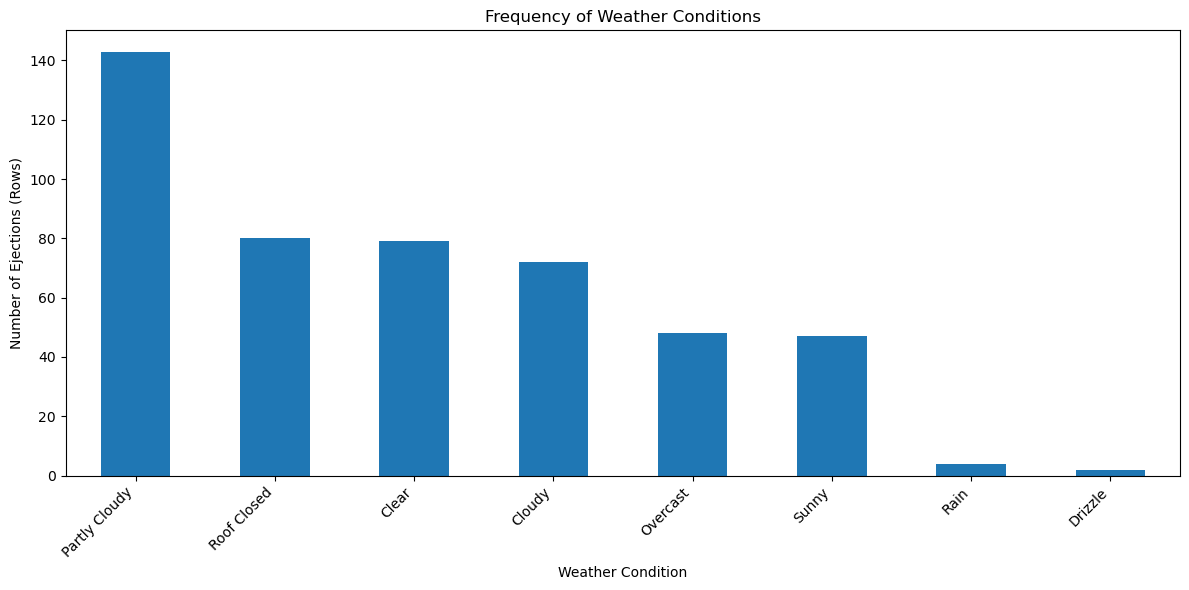

In [105]:
cond_counts = df["weather_condition"].value_counts().sort_values(ascending=False)

plt.figure()
cond_counts.plot(kind="bar")
plt.title("Frequency of Weather Conditions")
plt.xlabel("Weather Condition")
plt.ylabel("Number of Ejections (Rows)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


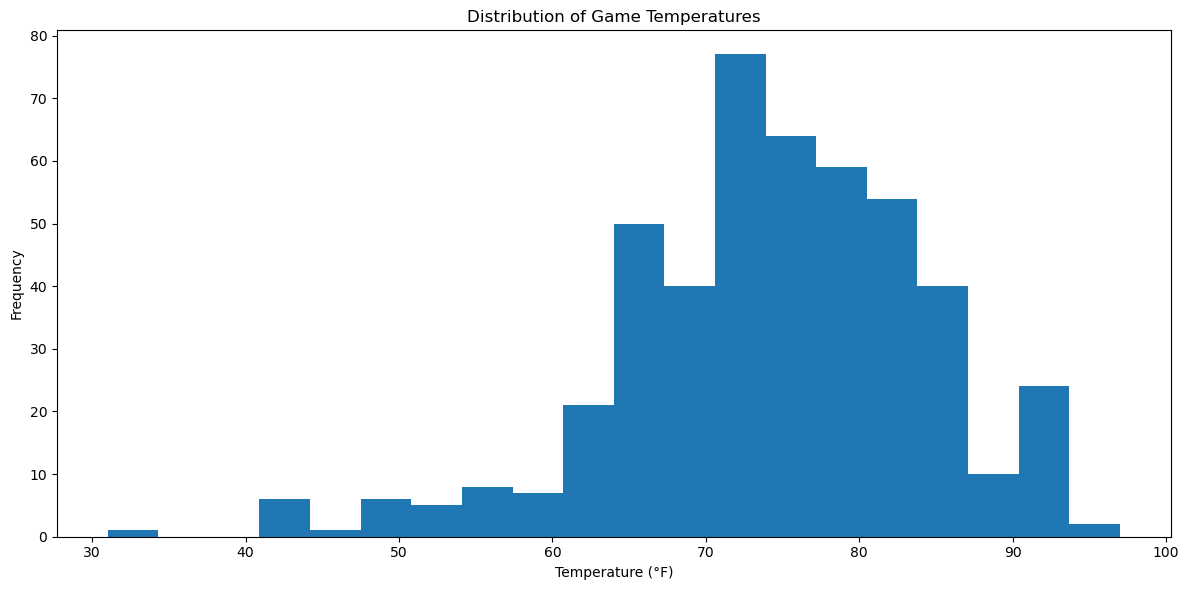

In [106]:
plt.figure()
df["weather_temp"].dropna().plot(kind="hist", bins=20)
plt.title("Distribution of Game Temperatures")
plt.xlabel("Temperature (°F)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


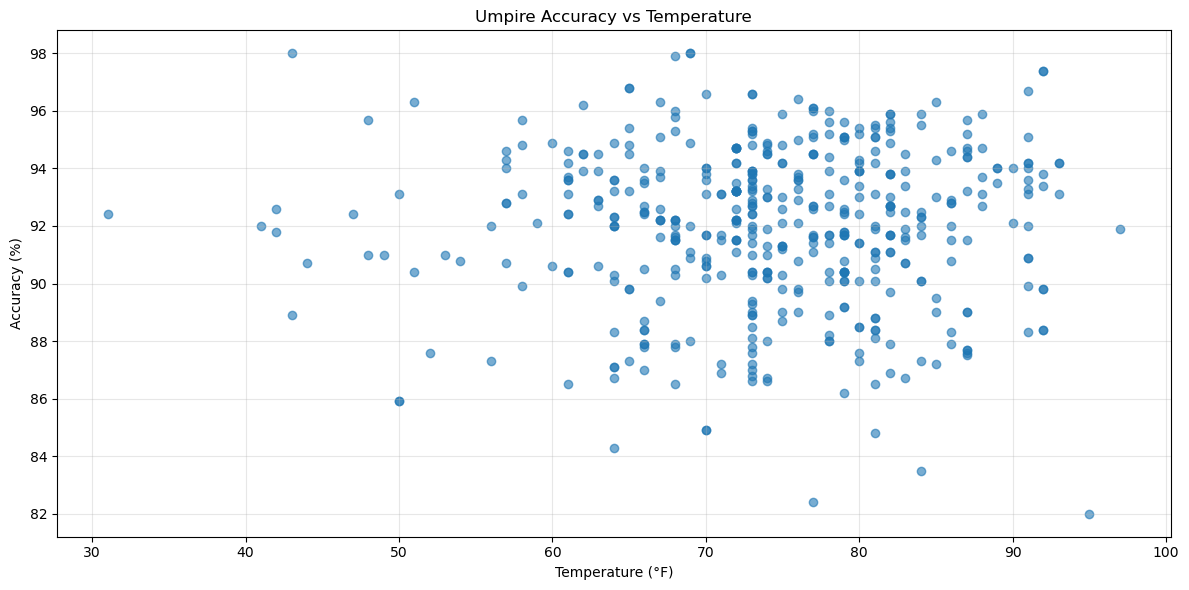

Correlation between temperature and accuracy:
              weather_temp  accuracy
weather_temp      1.000000  0.014015
accuracy          0.014015  1.000000


In [107]:
# Drop rows missing either temp or accuracy
temp_acc = df[["weather_temp", "accuracy"]].dropna()

# Scatter plot
plt.figure()
plt.scatter(temp_acc["weather_temp"], temp_acc["accuracy"], alpha=0.6)
plt.title("Umpire Accuracy vs Temperature")
plt.xlabel("Temperature (°F)")
plt.ylabel("Accuracy (%)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Correlation
print("Correlation between temperature and accuracy:")
print(temp_acc.corr())
